In [1]:
import torch.cuda as cuda

# 检查CUDA是否可用并获取GPU数量
device_count = cuda.device_count()
print(f"Number of available GPUs: {device_count}")

# 获取每个GPU的名称
for i in range(device_count):
    device_name = cuda.get_device_name(i)
    print(f"GPU {i+1}: {device_name}")

# 获取每个GPU的显存容量
for i in range(device_count):
    device_properties = cuda.get_device_properties(i)
    print(f"GPU {i+1} Memory: {device_properties.total_memory / 1024 / 1024} MB")

Number of available GPUs: 4
GPU 1: NVIDIA GeForce RTX 4090
GPU 2: NVIDIA GeForce RTX 4090
GPU 3: NVIDIA GeForce RTX 4090
GPU 4: NVIDIA GeForce RTX 4090
GPU 1 Memory: 24217.3125 MB
GPU 2 Memory: 24217.3125 MB
GPU 3 Memory: 24217.3125 MB
GPU 4 Memory: 24217.3125 MB


In [2]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
from monai.data import DataLoader, Dataset

import sys
# import itk

import SimpleITK as sitk
import time

import torch
# import segmentation_models_pytorch as smp
from torch.nn.functional import one_hot

from tqdm import tqdm
import matplotlib.pyplot as plt

2023-08-17 02:53:37.573370: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-17 02:53:38.598883: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
class Kit19Set(Dataset):
    def __init__(self, datapath, new_size, augmentation=None, preprocessing=None):
        self.datapath = datapath
        self.new_size = new_size
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        input_img_path = self.datapath+f"/case_{i:05d}/imaging.nii.gz"
        input_seg_path = self.datapath+f"/case_{i:05d}/segmentation.nii.gz"

        input_image = sitk.ReadImage(input_img_path)
        output_image = sitk.GetArrayFromImage(input_image)
        output_image = output_image.astype(np.float32)
        output_image = np.transpose(output_image, (2, 1, 0))
        output_image = torch.tensor(output_image)

        input_mask = sitk.ReadImage(input_seg_path)
        output_mask = sitk.GetArrayFromImage(input_mask)
        output_mask = output_mask.astype(np.float32)
        output_mask = np.transpose(output_mask, (2, 1, 0))
        output_mask = torch.tensor(output_mask)
        output_mask = one_hot(output_mask.long(), 3)
        output_mask = output_mask.permute(3, 1, 2, 0)


        if self.augmentation:
            sample = self.augmentation(image=output_image, mask=output_mask)
            output_image, output_mask = sample['image'], sample['mask']

        if self.preprocessing:
            sample = self.preprocessing(image=output_image, mask=output_mask)
            output_image, output_mask = sample['image'], sample['mask']

        return output_image, output_mask

    def __len__(self):
        return int(210)

In [4]:
new_size = [64, 128, 128]

dataset = Kit19Set("/home/featurize/data/resized_data_64_128", new_size=new_size)
train_size = int(0.8 * len(dataset))
vali_size = len(dataset) - train_size

# Use seed at 0 for reproducibility
torch.manual_seed(0)
train_dataset, vali_dataset = torch.utils.data.random_split(dataset, [train_size, vali_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=12)
vali_loader = DataLoader(vali_dataset, batch_size=4, shuffle=True, num_workers=12)
# dataloader = DataLoader(dataset=dataset, shuffle=False, batch_size=4)

In [5]:
import torch.nn.functional as F
class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=3, level_channels=[64, 128, 256], bottleneck_channel=512):
        super(UNet3D, self).__init__()

        self.maxpool3d = nn.MaxPool3d(kernel_size=2, stride=2)

        # Encoder part
        self.encoder1 = self._make_encoder_block(in_channels, level_channels[0])
        self.encoder2 = self._make_encoder_block(level_channels[0], level_channels[1])
        self.encoder3 = self._make_encoder_block(level_channels[1], level_channels[2])

        # Bottleneck part
        self.bottleneck = self._make_encoder_block(level_channels[2], bottleneck_channel)

        # Decoder part
        self.upconv3 = nn.ConvTranspose3d(bottleneck_channel, bottleneck_channel, kernel_size=2, stride=2)
        self.act = nn.ReLU(inplace=True)
        self.decoder3 = self._make_decoder_block(level_channels[2]+bottleneck_channel, level_channels[2])

        self.upconv2 = nn.ConvTranspose3d(level_channels[2], level_channels[2], kernel_size=2, stride=2)
        self.decoder2 = self._make_decoder_block(level_channels[1]+level_channels[2], level_channels[1])

        self.upconv1 = nn.ConvTranspose3d(level_channels[1], level_channels[1], kernel_size=2, stride=2)
        self.decoder1 = self._make_decoder_block(level_channels[0]+level_channels[1], level_channels[0])

        # Out layer conv
        self.outlayer = nn.Conv3d(in_channels=level_channels[0], out_channels=out_channels, kernel_size=1)
        self.soft = nn.Softmax(dim=0)

    def forward(self, x):

        # Encode part
        res1 = self.encoder1(x)
        x = self.maxpool3d(res1)

        res2 = self.encoder2(x)
        x = self.maxpool3d(res2)

        res3 = self.encoder3(x)
        x = self.maxpool3d(res3)

        # Bottleneck part
        x = self.bottleneck(x)
        # x = self.act(x)

        # Decode part
        x = self.upconv3(x)
        x = torch.cat((res3, x), dim=1)
        x = self.decoder3(x)

        x = self.upconv2(x)
        x = torch.cat((res2, x), dim=1)
        x = self.decoder2(x)

        x = self.upconv1(x)
        x = torch.cat((res1, x), dim=1)
        x = self.decoder1(x)

        # Out layer
        out = self.outlayer(x)
        # print(out.shape)
        # out = self.soft(x)
        out = F.softmax(out, dim=1)
        out = out.permute(0,1,3,4,2)
        # print(out.shape)

        return out

    def _make_encoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels//2, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels//2),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels//2, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def _make_decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )


In [6]:
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.metrics import MeanIoU
from monai.metrics import ConfusionMatrixMetric
from monai.metrics import get_confusion_matrix, compute_confusion_matrix_metric
# from monai.metrics import compute_meaniou
torch.cuda.set_device(1)
device = torch.device("cuda")
model = UNet3D()
# if device_count > 1:
#     model = nn.DataParallel(model)
#     print(f"Use {device_count} GPUs to train.")

model.to(device)

loss_function = DiceLoss(include_background=False).to(device)

train_dice_metric = DiceMetric(include_background=False, reduction="mean")
vali_dice_metric = DiceMetric(include_background=False, reduction="mean")

train_mean_iou_metric = MeanIoU(include_background=False, reduction="mean")
vali_mean_iou_metric = MeanIoU(include_background=False, reduction="mean")

# train_conf_matrix = ConfusionMatrixMetric(include_background=False, reduction="mean")


# loss_function = nn.CrossEntropyLoss()

In [7]:
learning_rate = 0.03
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
torch.cuda.empty_cache()
allocated_memory = torch.cuda.memory_allocated()
print(f"Allocated Memory: {allocated_memory / 1024 / 1024} MB")
cached_memory = torch.cuda.memory_cached()
print(f"Cached Memory: {cached_memory / 1024 / 1024} MB")

Allocated Memory: 73.54296875 MB
Cached Memory: 80.0 MB


/environment/miniconda3/lib/python3.10/site-packages/torch/cuda/memory.py:416: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [9]:
torch.cuda.empty_cache()
# torch.autograd.set_detect_anomaly(True)
start = time.time()
best_loss = float('inf')
train_loss_list, vali_loss_list = [], []
train_dice_list, vali_dice_list = [], []
train_iou_list, vali_iou_list = [], []
epoch = 100
true_epoch = 0
for e in range(epoch):
    model.train()

    train_loss = 0.0
    cm_list = []
    # iou = 0
    train_dice_metric.reset()
    train_mean_iou_metric.reset()
    per = 0
    tqdm.write(f"Epoch {e+1}/{epoch}")
    for img, mask in train_loader:
        torch.cuda.empty_cache()
        img = img.unsqueeze(1).to(device)
        # print(img.shape)
        # mask = mask.unsqueeze(1).to(device)
        mask = mask.to(device)
        # print(f"mask shape:{mask.shape}")
        
        optimizer.zero_grad()

        out = model(img)
        # out = out.permute(0,1,3,4,2)
        # out = torch.argmax(out, dim=1)
        # print(out.shape, mask.shape)
        # print(torch.all(out == 0))
        # print((np.unique(out.cpu())))
        # print(f"out shape:{out.shape}")

        # print("forward success.")

        loss = loss_function(out, mask)
        train_loss += loss.item()
        train_dice_metric((out>0.5).float(), mask)
        train_mean_iou_metric((out>0.5).float(), mask)
        # cm = get_confusion_matrix((out>0.5).float(), mask, include_background=False)
        # cm_list.append(cm.cpu())
        
        # meaniou = compute_meaniou((out>0.5).float(), mask, include_background=False)
        # iou += meaniou.sum().item()

        
        loss.backward()
        optimizer.step()
        
        per += 1
        percentage = per/len(train_loader)
        now = '='*int(percentage*50)+'>'
        left = '*'*int((1-percentage)*50)
        percen = format(percentage*100, '.2f')
        print("\r", now + left + '\t' + f"{percen}" + '%', end="", flush=True)

        # print("optimize success.")
    epoch_loss = train_loss / len(train_loader)
    train_mean_dice = train_dice_metric.aggregate().item()
    train_mean_iou = train_mean_iou_metric.aggregate().item()
    # tqdm.write(f"Train Loss: {epoch_loss}")
    train_loss_list.append(epoch_loss)
    train_dice_list.append(train_mean_dice)
    train_iou_list.append(train_mean_iou)
    print("\ntrain dice loss is: " + f"{epoch_loss:.4f}\t" + "train mean dice is: " + f"{train_mean_dice:.4f}\t" 
          + "train mean IoU is: " + f"{train_mean_iou:.4f}")
    # cm_array = np.vstack(cm_list)
    # print(cm_array.shape)
    # total_cm = np.sum(cm_array, axis=0)
    # print(total_cm.shape)
    # total_cm = np.sum(cm_array, axis=0)
    # print(total_cm.shape)
    
    
    
    model.eval()
    eval_loss = 0.0
    vali_dice_metric.reset()
    vali_mean_iou_metric.reset()
    with torch.no_grad():
        for img, mask in vali_loader:
            torch.cuda.empty_cache()
            img = img.unsqueeze(1).to(device)
            # print(img.shape)
            # mask = mask.unsqueeze(1).to(device)
            mask = mask.to(device)

            out = model(img)
            # out = out.permute(0,1,3,4,2)

            loss = loss_function(out, mask)
            eval_loss += loss.item()
            vali_dice_metric((out>0.5).float(), mask)
            vali_mean_iou_metric((out>0.5).float(), mask)
    vali_loss = eval_loss / len(vali_loader)
    vali_mean_dice = vali_dice_metric.aggregate().item()
    vali_mean_iou = vali_mean_iou_metric.aggregate().item()
    # tqdm.write(f"Validation Loss: {vali_loss}")
    vali_loss_list.append(vali_loss)
    vali_dice_list.append(vali_mean_dice)
    vali_iou_list.append(vali_mean_iou)
    
    print(f"vali dice loss is: " + f"{vali_loss:.4f}\t" + "vali mean dice is: " + f"{vali_mean_dice:.4f}\t" 
          + "vali mean IoU is: " + f"{vali_mean_iou:.4f}\n")
    
    if vali_loss < best_loss:
        best_loss = vali_loss
        torch.save(model.state_dict(), "./Adam_0.0001/best_model.pth")
    
    true_epoch += 1

end = time.time()
print(f"Costs {end-start}s.")

Epoch 1/100
 ==================================================>	100.00%
train dice loss is: 0.9692	train mean dice is: 0.0298	train mean IoU is: 0.0158
vali dice loss is: 1.0000	vali mean dice is: 0.0000	vali mean IoU is: 0.0000

Epoch 2/100
 ==================================================>	100.00%
train dice loss is: 0.9001	train mean dice is: 0.0994	train mean IoU is: 0.0565
vali dice loss is: 0.9956	vali mean dice is: 0.0021	vali mean IoU is: 0.0011

Epoch 3/100
 ==================================================>	100.00%
train dice loss is: 0.7880	train mean dice is: 0.2122	train mean IoU is: 0.1345
vali dice loss is: 0.8607	vali mean dice is: 0.1422	vali mean IoU is: 0.0850

Epoch 4/100
 ==================================================>	100.00%
train dice loss is: 0.7433	train mean dice is: 0.2569	train mean IoU is: 0.1686
vali dice loss is: 0.7870	vali mean dice is: 0.2110	vali mean IoU is: 0.1365

Epoch 5/100
 ==================================================>	100.00%
tra

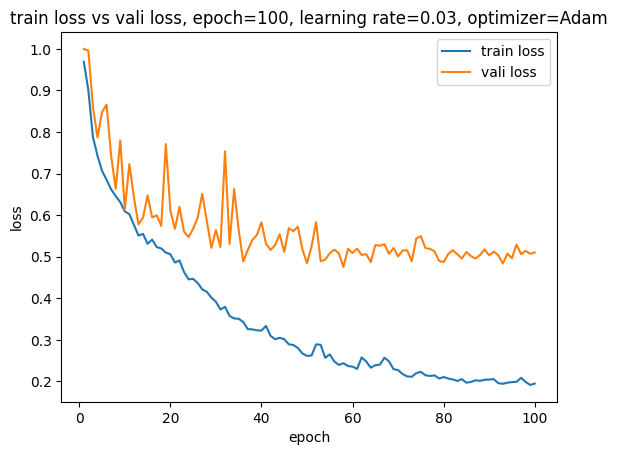

In [11]:
plt.figure()
x = range(1, true_epoch+1)
# print(true_epoch)
loss1, loss2 = train_loss_list, vali_loss_list
# print(loss1)
plt.title(f'train loss vs vali loss, epoch={true_epoch}, learning rate={learning_rate}, optimizer=Adam')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(x, loss1, label='train loss')
plt.plot(x, loss2, label='vali loss')
plt.legend()
plt.savefig('./Adam_0.0001/loss_plot.png')
plt.show()

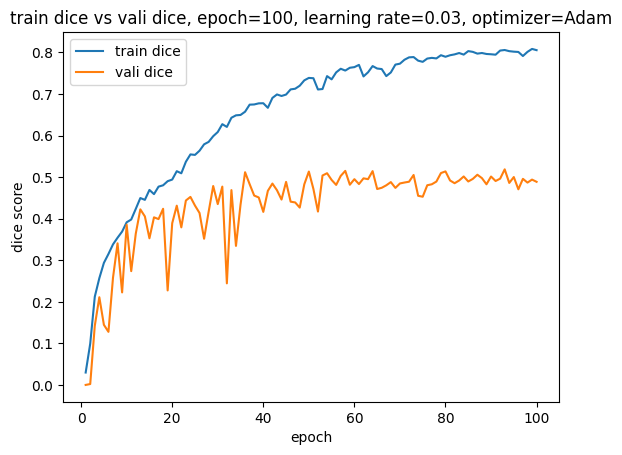

In [12]:
plt.figure()
x = range(1, true_epoch+1)
# print(true_epoch)
loss1, loss2 = train_dice_list, vali_dice_list
# print(loss1)
plt.title(f'train dice vs vali dice, epoch={true_epoch}, learning rate={learning_rate}, optimizer=Adam')
plt.xlabel('epoch')
plt.ylabel('dice score')
plt.plot(x, loss1, label='train dice')
plt.plot(x, loss2, label='vali dice')
plt.legend()
plt.savefig('./Adam_0.0001/dice_plot.png')
plt.show()

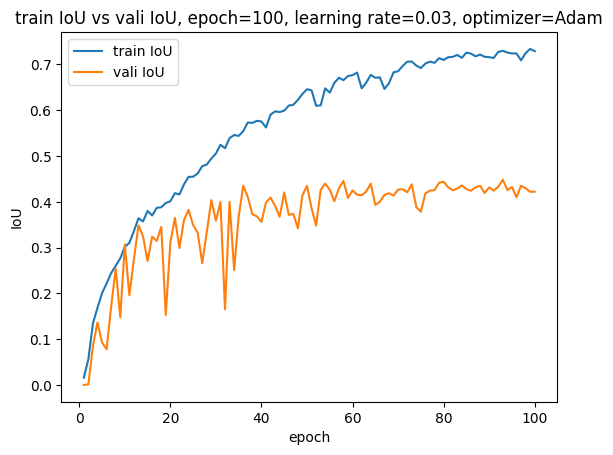

In [13]:
plt.figure()
x = range(1, true_epoch+1)
# print(true_epoch)
loss1, loss2 = train_iou_list, vali_iou_list
# print(loss1)
plt.title(f'train IoU vs vali IoU, epoch={true_epoch}, learning rate={learning_rate}, optimizer=Adam')
plt.xlabel('epoch')
plt.ylabel('IoU')
plt.plot(x, loss1, label='train IoU')
plt.plot(x, loss2, label='vali IoU')
plt.legend()
plt.savefig('./Adam_0.0001/IoU_plot.png')
plt.show()

In [7]:
import os
class TestKit19Set(Dataset):
    def __init__(self, datapath, new_size, augmentation=None, preprocessing=None):
        self.datapath = datapath
        self.new_size = new_size
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        input_img_path = self.datapath+f"/case_{i+210:05d}/imaging.nii.gz"
        # input_seg_path = self.datapath+f"/case_{i:05d}/segmentation.nii.gz"

        input_image = sitk.ReadImage(input_img_path)
        # print(type(input_image))

        # Get the current spacing and size of the input image
        input_spacing = input_image.GetSpacing()
        input_size = input_image.GetSize()

        # Compute the desired spacing based on the new size
        new_spacing = [old_sz * old_spc / new_sz for old_sz, old_spc, new_sz in
                       zip(input_size, input_spacing, self.new_size)]

        # Create the resampling transformation
        resampler = sitk.ResampleImageFilter()
        resampler.SetSize(self.new_size)
        resampler.SetOutputSpacing(new_spacing)
        resampler.SetOutputOrigin(input_image.GetOrigin())
        resampler.SetOutputDirection(input_image.GetDirection())

        # Perform the resampling
        output_image = resampler.Execute(input_image)
        # folder_path = f"/test_visual/case_{i + 210:05d}"
        # if not os.path.exists(folder_path):
            # os.makedirs(folder_path)
        output_filename = f"./test_visual/case_{i + 210:05d}/imaging.nii.gz"
        sitk.WriteImage(output_image, output_filename)
        output_image = sitk.GetArrayFromImage(output_image)
        output_image = output_image.astype(np.float32)
        output_image = np.transpose(output_image, (2, 1, 0))

        return output_image
        # return output_image, output_mask

    def __len__(self):
        return int(90)

In [8]:
test_set = TestKit19Set("data", new_size=[64, 256, 256])
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

In [9]:
device = torch.device("cuda")
model = UNet3D()
model.load_state_dict(torch.load("./work/new_best_model_3.pth"))

model.to(device)

from tqdm.notebook import tqdm_notebook
torch.cuda.empty_cache()
tqdm_notebook.monitor_interval = 0
for i, img in tqdm_notebook(enumerate(test_loader),desc="Batch progress", leave=False):
    with torch.no_grad():
        img = img.unsqueeze(1).to(device)
        # print(img.shape)
        out = model(img)
        # print(out.shape)
        out = torch.squeeze(out)
        out = out.permute(0,3,1,2)
        # print(out.shape)
        # print(out.shape)
        # print(out[0,24,24,24], out[1,24,24,24],out[2,24,24,24])
        # print(out[0, 36, 36, 36], out[1, 36, 36, 36], out[2, 36, 36, 36])
        # the output shape is [3, 64, 128,128]

        out = torch.argmax(out, dim=0)
        # the shape will be [64,128,128]
        # print(out.shape)
        # is_all_zero = torch.all(out == 0)
        # print("Is the tensor all zero?", is_all_zero)
        # print(out.shape)
        # unique = np.unique(out)
        # print(len(unique))
        
        out = out.cpu()
        out = out.detach().numpy()
        out = np.transpose(out, (2, 1, 0))
        # unique = np.unique(out)
        # print(out.shape)
        out = sitk.GetImageFromArray(out)
        # print(out.GetSize(), type(out))
        output_filename = f"./test_visual/case_{i+210:05d}/segmentation.nii.gz"
        # print(output_filename)
        sitk.WriteImage(out, output_filename)

Batch progress: 0it [00:00, ?it/s]